<a href="https://colab.research.google.com/github/j82887/1st-DL-CVMarathon/blob/master/Suicide_20200303.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#所需運用的函式
import numpy as np
import pandas as pd
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split #分為訓練與測試集
from sklearn.preprocessing import MinMaxScaler #正規化
import matplotlib.pyplot as plt #繪圖

#機器學習的模型
from sklearn.linear_model import LogisticRegression #邏輯回歸
from sklearn import tree #決策樹
from sklearn.ensemble import RandomForestClassifier #隨機森林
from sklearn.ensemble import GradientBoostingClassifier #梯度提升回歸樹
from sklearn.neural_network import MLPClassifier #多層感知器
from sklearn.naive_bayes import MultinomialNB #貝葉斯分類器
from sklearn.svm import SVC #支持向量機

from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix #混淆矩陣
from sklearn.metrics import accuracy_score #準確度
from imblearn.metrics import specificity_score
from imblearn.metrics import sensitivity_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
import scipy.stats as stats

In [81]:
from google.colab import files
# 上傳CSV
uploaded = files.upload()

Saving New_Data.xlsx to New_Data (1).xlsx
Saving New_Feature_no_BSRS.csv to New_Feature_no_BSRS (1).csv
Saving New_Feature_Paper.csv to New_Feature_Paper (1).csv
Saving New_Label_1.csv to New_Label_1 (1).csv
Saving New_Label_2.csv to New_Label_2 (1).csv


In [0]:
import io
Data_paper = pd.read_csv(io.BytesIO(uploaded['New_Feature_Paper.csv']))
Data_nobsrs = pd.read_csv(io.BytesIO(uploaded['New_Feature_no_BSRS.csv']))
Label_1 = pd.read_csv(io.BytesIO(uploaded['New_Label_1.csv']))
Label_2 = pd.read_csv(io.BytesIO(uploaded['New_Label_2.csv']))
Suicide = pd.read_excel(io.BytesIO(uploaded['New_Data.xlsx']))

In [83]:
#資料的讀取(特徵與標籤)
#Data_paper = pd.read_csv(r"C:\Users\哲旻\Desktop\自殺研究\Suicide_New\Suicide Result 1\New_Feature_Paper.csv")
#Data_nobsrs = pd.read_csv(r"C:\Users\哲旻\Desktop\自殺研究\Suicide_New\Suicide Result 1\New_Feature_no_BSRS.csv")
#Label_1 = pd.read_csv(r"C:\Users\哲旻\Desktop\自殺研究\Suicide_New\Suicide Result 1\New_Label_1.csv")
#Label_2 = pd.read_csv(r"C:\Users\哲旻\Desktop\自殺研究\Suicide_New\Suicide Result 1\New_Label_2.csv")
#Suicide = pd.read_excel(r"C:\Users\哲旻\Desktop\自殺研究\Suicide_New\Suicide Result 1\New_Data.xlsx")

#轉為陣列
data_paper_names = Data_paper.columns
data_paper = Data_paper.as_matrix()
label_1 = Label_1['Label >= 1']

print("\n投稿的原始特徵：")
print(data_paper_names)
print("投稿的原始特徵 類別數量： %s" %Counter(label_1))

data_nobsrs_names = Data_nobsrs.columns
data_nobsrs = Data_nobsrs.as_matrix()
label_2 = Label_2['Label >= 2']

print("\n去除BSRS的特徵：")
print(data_nobsrs_names)
print("去除BSRS的特徵 類別數量： %s" %Counter(label_2))

suicide = Suicide['Suicide']
print("\n自殺意念：%s" %Counter(suicide))

bsrs = Suicide['bars_score']
print("\nBSRS：%s" %Counter(bsrs))


投稿的原始特徵：
Index(['Sleep', 'Disturbed', 'Distressed', 'Depression', 'Non_compare',
       'bars_score'],
      dtype='object')
投稿的原始特徵 類別數量： Counter({0: 3418, 1: 128})

去除BSRS的特徵：
Index(['Sleep', 'Disturbed', 'Distressed', 'Depression', 'Non_compare'], dtype='object')
去除BSRS的特徵 類別數量： Counter({0: 3504, 1: 42})

自殺意念：Counter({0: 3418, 1: 86, 2: 19, 3: 13, 4: 10})

BSRS：Counter({0: 1841, 1: 355, 3: 256, 5: 252, 4: 243, 2: 241, 6: 119, 7: 59, 8: 58, 10: 37, 9: 36, 12: 13, 11: 10, 13: 8, 16: 4, 20: 4, 14: 3, 15: 3, 17: 3, 18: 1})


In [0]:
def bsrs_predict_data(bsrs, k):
    bsrs_predict = []
    for i in range(len(bsrs)):
        if bsrs[i] >= k:
            bsrs_predict.append(1)
        else:
            bsrs_predict.append(0)

    return np.array(bsrs_predict)

In [7]:
#正規化
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(data_nobsrs)
X_Data = scaler.transform(data_nobsrs)

#隨機亂數分訓練集與測試集
X_train, X_test, y_train, y_test = train_test_split(X_Data, label_2,random_state=0) 
_, X_suicide, _, _ = train_test_split(suicide, label_1,random_state=0) 

#SMOTE
smote = SMOTE(sampling_strategy = 1,random_state=0)
X_train, y_train = smote.fit_sample(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


測試集之最高F1分數:0.092
最佳的C:0.070


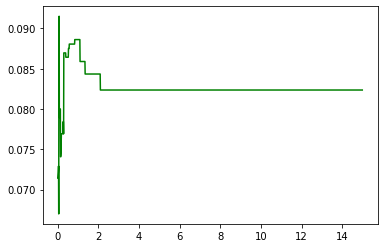

<Figure size 7200x7200 with 0 Axes>

In [8]:
#邏輯回歸
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

best_score1 = 0
score_save = []
parameter_save = []

for C in np.arange(0.01, 15, 0.01):
    model1 = LogisticRegression(C=C, random_state=0)
    model1.fit(X_train,y_train.ravel())
    
    y_predict_test = model1.predict(X_test)
    score1 = f1_score(y_test, y_predict_test)
    
    if score1 > best_score1:
        best_score1 = score1
        best_C = C
    
    score_save.append(score1)
    parameter_save.append(C)
    
Hyperparameter_1 = best_C
print("測試集之最高F1分數:{:.3f}".format(best_score1))  
print("最佳的C:{:.3f}".format(best_C))

plt.plot(parameter_save,score_save, color='green') 
plt.figure(figsize=(100,100))
plt.show()

測試集之最高F1分數:0.300
最佳的max_depth:3.000


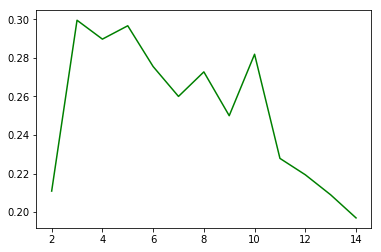

In [0]:
#決策樹

best_score2 = 0
score_save = []
parameter_save = []

for max_depth1 in np.arange(2, 15, 1):
    model2 = tree.DecisionTreeClassifier(max_depth=max_depth1,random_state=0)
    model2.fit(X_train,y_train.ravel())  
    
    y_predict_test = model2.predict(X_test)
    score2 = f1_score(y_test, y_predict_test)
    
    if score2 > best_score2:
        best_score2 = score2
        best_max_depth1 = max_depth1
        
    score_save.append(score2)
    parameter_save.append(max_depth1)        

Hyperparameter_2 = best_max_depth1
print("測試集之最高F1分數:{:.3f}".format(best_score2))  
print("最佳的max_depth:{:.3f}".format(best_max_depth1))

plt.plot(parameter_save,score_save,color='green') 
plt.show()

測試集之最高F1分數:0.164
最佳的N:  62


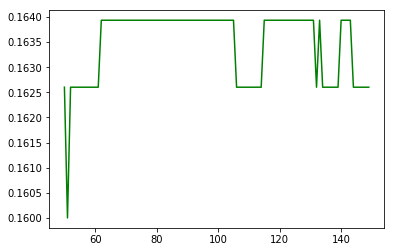

In [0]:
#隨機森林

best_score3 = 0
score_save = []
parameter_save = []

for N in np.arange(50, 150, 1):
    model3 = RandomForestClassifier(n_estimators=N,random_state=0)
    model3.fit(X_train,y_train.ravel())
    
    y_predict_test = model3.predict(X_test)
    score3 = f1_score(y_test, y_predict_test)
    
    if score3 > best_score3:
        best_score3 = score3
        best_N = N
        
    score_save.append(score3)
    parameter_save.append(N)

Hyperparameter_3 = best_N
print("測試集之最高F1分數:{:.3f}".format(best_score3))  
print('最佳的N: ', best_N)

plt.plot(parameter_save,score_save, color='green') 
plt.show()

測試集之最高F1分數:0.303
最佳的max_depth:  2


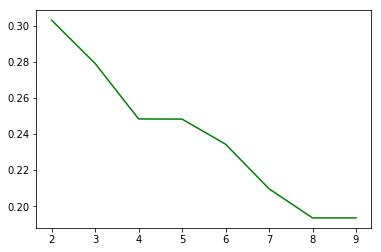

In [0]:
#梯度提升回歸樹

best_score4 = 0
score_save = []
parameter_save = []

for max_depth2 in np.arange(2, 10, 1):
    model4 = GradientBoostingClassifier(max_depth=max_depth2,random_state=0)
    model4.fit(X_train,y_train.ravel())
    
    y_predict_test = model4.predict(X_test)
    score4 = f1_score(y_test, y_predict_test)
    
    if score4 > best_score4:
        best_score4 = score4
        best_max_depth2 = max_depth2
        
    score_save.append(score4)
    parameter_save.append(max_depth2)

Hyperparameter_4 = best_max_depth2
print("測試集之最高F1分數:{:.3f}".format(best_score4))  
print('最佳的max_depth: ', best_max_depth2)

plt.plot(parameter_save,score_save, color='green') 
plt.show()

In [0]:
#支持向量機

best_score6 = 0
score_save = [] 
parameter1_save = []
parameter2_save = []

for C2 in np.arange(1, 10, 1): 
    model6 = SVC(C=C2,random_state=0, probability=True,kernel='linear')
    model6.fit(X_train,y_train.ravel())
        
    y_predict_test = model6.predict(X_test)
    score6 = f1_score(y_test, y_predict_test)
        
    if score6 > best_score6:
        best_score6 = score6
        best_C2 = C2

    score_save.append(score6)
    parameter1_save.append(C2)

        
Hyperparameter_5 = best_C2       
print("測試集之最高F1分數:{:.3f}".format(best_score6))
print("最佳的C:{:.3f}".format(best_C2)) 

測試集之最高F1分數:0.237
最佳的C:3.000


測試集之最高F1分數:0.250
最佳的C:0.760


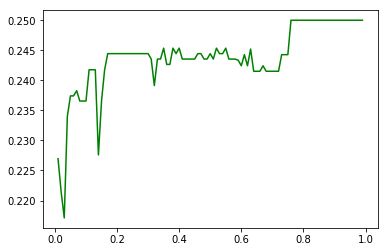

In [0]:
#多層感知器

best_score7 = 0
score_save = []
parameter_save = []

for C2 in np.arange(0.01, 1, 0.01):
    model7 = MLPClassifier(max_iter=1000, alpha=C2, random_state=0,hidden_layer_sizes=(5,10))
    model7.fit(X_train,y_train.ravel())
    y_predict_test = model7.predict(X_test)
    score7 = f1_score(y_test, y_predict_test)
    
    if score7 > best_score7:
        best_score7 = score7
        best_C2 = C2
    
    score_save.append(score7)
    parameter_save.append(C2)

Hyperparameter_6 = best_C2
print("測試集之最高F1分數:{:.3f}".format(best_score7))  
print("最佳的C:{:.3f}".format(best_C2))

plt.plot(parameter_save,score_save, color='green') 
plt.show()

In [0]:
model1 = LogisticRegression(C=Hyperparameter_1, random_state=0)
model1.fit(X_train,y_train.ravel())

model2 = tree.DecisionTreeClassifier(max_depth=Hyperparameter_2,random_state=0)
model2.fit(X_train,y_train.ravel())  

model3 = RandomForestClassifier(n_estimators=Hyperparameter_3,random_state=0)
model3.fit(X_train,y_train.ravel())

model4 = GradientBoostingClassifier(max_depth=Hyperparameter_4,random_state=0)
model4.fit(X_train,y_train.ravel())

model5 = SVC(C=Hyperparameter_5,random_state=0, probability=True,kernel='linear')
model5.fit(X_train,y_train.ravel())

model6 = MLPClassifier(max_iter=10000, alpha=Hyperparameter_6, random_state=0,hidden_layer_sizes=(6,12,24))
model6.fit(X_train,y_train.ravel())

model_list = [model1, model2, model3, model4, model5, model6]
name_list = ["邏輯回歸", "決策樹", "隨機森林", "梯度提升決策樹", "支持向量機", "多層感知器"]

for i in range(len(model_list)):
#predict
    print("====== %s ======" %(name_list[i]))

    y_predict_train = model_list[i].predict(X_train)
    y_predict_test = model_list[i].predict(X_test)

    confusion_train = confusion_matrix(y_train, y_predict_train)
    confusion_test = confusion_matrix(y_test, y_predict_test)
    accuracy_train = accuracy_score(y_train, y_predict_train)
    accuracy_test = accuracy_score(y_test, y_predict_test)

    #print("訓練集的混淆矩陣:\n{}".format(confusion_train))
    print("測試集的混淆矩陣:\n{}".format(confusion_test))
    #print("訓練集之準確度:{:.3f}".format(accuracy_train))
    print("測試集之準確度:{:.3f}".format(accuracy_test))

    Sen = sensitivity_score(y_test, y_predict_test)
    print("測試集之敏感度:{:.3f}".format(Sen))

    Spe = specificity_score(y_test, y_predict_test)
    print("測試集之特異度:{:.3f}".format(Spe))
    
    Precision = precision_score(y_test, y_predict_test)
    print("測試集之查準率:{:.3f}".format(Precision))

    f1_score_test = f1_score(y_test, y_predict_test)
    print("測試集之F1分數:{:.3f}".format(f1_score_test))

    Predict_test = model_list[i].predict_proba(X_test)[:,1]

    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=Predict_test) 
    roc_auc = auc(x=fpr, y=tpr)
    print("測試集ROC之AUC:{:.3f}".format(roc_auc))

    precision, recall, thresholds = precision_recall_curve(y_test, Predict_test)
    pr_auc = auc(x=recall, y=precision)
    print("測試集PR之AUC:{:.3f}".format(pr_auc))

    Pearson_Suicide = stats.pearsonr(X_suicide, Predict_test)
    print("相關係數:{:.5f}".format(Pearson_Suicide[0]))
    print("P值:{:.5f}".format(Pearson_Suicide[1]))
    

====== 邏輯回歸 ======
測試集的混淆矩陣:
[[674 179]
 [  3  31]]
測試集之準確度:0.795
測試集之敏感度:0.912
測試集之特異度:0.790
測試集之查準率:0.148
測試集之F1分數:0.254
測試集ROC之AUC:0.926
測試集PR之AUC:0.369
相關係數:0.32294
P值:0.00000
====== 決策樹 ======
測試集的混淆矩陣:
[[711 142]
 [  3  31]]
測試集之準確度:0.837
測試集之敏感度:0.912
測試集之特異度:0.834
測試集之查準率:0.179
測試集之F1分數:0.300
測試集ROC之AUC:0.908
測試集PR之AUC:0.406
相關係數:0.30335
P值:0.00000
====== 隨機森林 ======
測試集的混淆矩陣:
[[775  78]
 [ 24  10]]
測試集之準確度:0.885
測試集之敏感度:0.294
測試集之特異度:0.909
測試集之查準率:0.114
測試集之F1分數:0.164
測試集ROC之AUC:0.790
測試集PR之AUC:0.151
相關係數:0.21115
P值:0.00000
====== 梯度提升決策樹 ======
測試集的混淆矩陣:
[[719 134]
 [  4  30]]
測試集之準確度:0.844
測試集之敏感度:0.882
測試集之特異度:0.843
測試集之查準率:0.183
測試集之F1分數:0.303
測試集ROC之AUC:0.895
測試集PR之AUC:0.277
相關係數:0.31050
P值:0.00000
====== 支持向量機 ======
測試集的混淆矩陣:
[[642 211]
 [  1  33]]
測試集之準確度:0.761
測試集之敏感度:0.971
測試集之特異度:0.753
測試集之查準率:0.135
測試集之F1分數:0.237
測試集ROC之AUC:0.918
測試集PR之AUC:0.303
相關係數:0.31555
P值:0.00000
====== 多層感知器 ======
測試集的混淆矩陣:
[[662 191]
 [  3  31]]
測試集之準確度:0.781
測試集之敏感度:0.912
測試集之特異度:0.776
測試

In [0]:
def model_Verification(y_test, X_suicide, y_predict_test, Predict_test):
    
    confusion = confusion_matrix(y_test, y_predict_test)
    acc = accuracy_score(y_test, y_predict_test)
    sen = sensitivity_score(y_test, y_predict_test)
    spe = specificity_score(y_test, y_predict_test)
    pre = precision_score(y_test, y_predict_test)
    f1 = f1_score(y_test, y_predict_test)
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=Predict_test) 
    roc_auc = auc(x=fpr, y=tpr)
    precision, recall, thresholds = precision_recall_curve(y_test, Predict_test)
    pr_auc = auc(x=recall, y=precision)
    pearson_r, pearson_pvalue = stats.pearsonr(X_suicide, Predict_test)
    
    #print("混淆矩陣:\n{}".format(confusion))
    #print("準確度:{:.3f}".format(acc))
    #print("敏感度:{:.3f}".format(sen))
    #print("特異度:{:.3f}".format(spe))
    #print("查準率:{:.3f}".format(pre))
    #print("測試集之F1分數:{:.3f}".format(f1))
    #print("ROC之AUC:{:.3f}".format(roc_auc))
    #print("PR之AUC:{:.3f}".format(pr_auc))
    #print("相關係數:{:.5f}".format(pearson_r))
    #print("P值:{:.5f}".format(pearson_pvalue))

    return acc, sen, spe, pre, f1, roc_auc, pr_auc, pearson_r

In [0]:
#交叉驗證所需要的驗證集
def CrossTestSet(Feature, Label, number):
    
    #變數初始化
    FeatureList, LabelList = [], []

    
    j = number
    for i in range(0,j-1 ,1):
        size = 1 / number
        
        #依序二元切割至k格
        Feature, CutFeature, Label, CutLabel = train_test_split(Feature, Label, random_state = 0, test_size = size) #0
       
        #切割後儲存至列表
        FeatureList.append(CutFeature)
        LabelList.append(CutLabel)

        number = number - 1
    
    #最後一次切割的樣本儲存至列表
    FeatureList.append(Feature)
    LabelList.append(Label)
    
    return FeatureList, LabelList

In [0]:
##交叉驗證所需要的訓練集
def CrossTrainSet(FeatureList, LabelList, CutNumber):

    #變數初始化
    Lenght = 0
    Train, Label = [], []
    TemporaryData, TemporaryLabel = [], []
    Data_x, Data_y = [], []

    #將已經切割好的測試集串接
    for i in range(0, CutNumber, 1):
        Data_x.extend(FeatureList[i])
        Data_y.extend(LabelList[i])
    
    #取每格的元素排列串接
    for i in range(0, CutNumber, 1):
    
        #第一次的儲存
        if(i==0):
            Train.append(Data_x[len(FeatureList[0]):])
            Label.append(Data_y[len(LabelList[0]):])
        
        #最後一次的儲存
        if(i==CutNumber-1):
            Train.append(Data_x[0:Lenght])
            Label.append(Data_y[0:Lenght])
            
        Lenght = Lenght+len(FeatureList[i])
        
        #中間的儲存(存前面與後面)
        if((i!=0)&(i!=CutNumber-1)):   
            FrontTemporaryData = TemporaryData
            FrontTemporaryData.extend(Data_x[Lenght:])
            Train.append(FrontTemporaryData)
        
            FrontTemporaryLabel = TemporaryLabel
            FrontTemporaryLabel.extend(Data_y[Lenght:])
            Label.append(FrontTemporaryLabel)
        
        #暫存目前跑過的列表內的元素
        TemporaryData = Data_x[:Lenght]
        TemporaryLabel = Data_y[:Lenght]
    
    #print("訓練集特徵的陣列個數：",len(Train))
    #print("訓練集標籤的陣列個數：",len(Label))
    
    return Train, Label

    #注意上面皆是列表

In [126]:
#正規化
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(data_nobsrs)
X_Data = scaler.transform(data_nobsrs)
 
cv_x, cv_y = CrossTestSet(X_Data, label_2, 10)
train_x, train_y = CrossTrainSet(cv_x, cv_y, 10)

cv_suicide, _ = CrossTestSet(suicide, label_2, 10)
cv_bsrs, _ = CrossTestSet(bsrs, label_2, 10)

for i in range(len(cv_y)):
    print("第 %s 次：" %(i+1))
    print("訓練集之樣本%s" %Counter(train_y[i]))
    print("驗證集之樣本%s" %Counter(cv_y[i]))
    print("BSRS%s" %Counter(cv_bsrs[i]))

第 1 次：
訓練集之樣本Counter({0: 3151, 1: 40})
驗證集之樣本Counter({0: 353, 1: 2})
BSRSCounter({0: 202, 1: 27, 5: 25, 2: 24, 3: 23, 4: 20, 6: 14, 7: 6, 8: 5, 10: 5, 16: 1, 11: 1, 14: 1, 13: 1})
第 2 次：
訓練集之樣本Counter({0: 3152, 1: 39})
驗證集之樣本Counter({0: 352, 1: 3})
BSRSCounter({0: 174, 1: 40, 4: 30, 3: 28, 5: 28, 2: 25, 6: 10, 7: 6, 9: 5, 8: 5, 10: 3, 13: 1})
第 3 次：
訓練集之樣本Counter({0: 3155, 1: 36})
驗證集之樣本Counter({0: 349, 1: 6})
BSRSCounter({0: 190, 1: 39, 2: 27, 4: 27, 3: 21, 5: 21, 6: 13, 8: 4, 9: 3, 12: 3, 11: 2, 14: 1, 20: 1, 16: 1, 7: 1, 17: 1})
第 4 次：
訓練集之樣本Counter({0: 3153, 1: 38})
驗證集之樣本Counter({0: 351, 1: 4})
BSRSCounter({0: 180, 1: 34, 3: 31, 4: 27, 2: 26, 5: 23, 6: 14, 7: 6, 8: 4, 9: 4, 11: 2, 10: 2, 13: 1, 18: 1})
第 5 次：
訓練集之樣本Counter({0: 3152, 1: 39})
驗證集之樣本Counter({0: 352, 1: 3})
BSRSCounter({0: 186, 1: 35, 3: 30, 4: 25, 2: 22, 5: 20, 6: 11, 7: 10, 8: 7, 9: 3, 12: 2, 16: 1, 10: 1, 11: 1, 20: 1})
第 6 次：
訓練集之樣本Counter({0: 3154, 1: 37})
驗證集之樣本Counter({0: 350, 1: 5})
BSRSCounter({0: 171, 1: 40,

In [0]:
Hyperparameter_1 = 0.38
Hyperparameter_2 = 3
Hyperparameter_3 = 62
Hyperparameter_4 = 2
Hyperparameter_5 = 3
Hyperparameter_6 = 0.76

In [0]:
Hyperparameter_1 = 0.07
Hyperparameter_2 = 9
Hyperparameter_3 = 50
Hyperparameter_4 = 5
Hyperparameter_5 = 1
Hyperparameter_6 = 0.04

In [0]:
def save_value(acc, sen, spe, pre, f1, roc_auc, pr_auc, pearson_r, i, acc_save, sen_save, spe_save, pre_save, f1_save, roc_auc_save, pr_auc_save, pearson_r_save, fold_save):
    acc_save.append(acc)
    sen_save.append(sen)
    spe_save.append(spe)
    pre_save.append(pre)
    f1_save.append(f1)
    roc_auc_save.append(roc_auc)
    pr_auc_save.append(pr_auc)
    pearson_r_save.append(pearson_r)
    fold_save.append(i)

    return acc_save, sen_save, spe_save, pre_save, f1_save, roc_auc_save, pr_auc_save, pearson_r_save, fold_save


In [0]:
#儲存
acc_save, sen_save, spe_save, pre_save, f1_save, roc_auc_save, pr_auc_save, pearson_r_save, fold_save


excel_Predict = pd.DataFrame(acc_save,columns=['acc'])
excel_Predict['sen'] = pd.Series(sen_save, index=excel_Predict.index)
excel_Predict['spe'] = pd.Series(spe_save, index=excel_Predict.index)
excel_Predict['pre'] = pd.Series(pre_save, index=excel_Predict.index)
excel_Predict['f1'] = pd.Series(f1_save, index=excel_Predict.index)
excel_Predict['roc_auc'] = pd.Series(roc_auc_save, index=excel_Predict.index)
excel_Predict['pr_auc'] = pd.Series(pr_auc_save, index=excel_Predict.index)
excel_Predict['pearson_r'] = pd.Series(pearson_r_save, index=excel_Predict.index)
excel_Predict['fold'] = pd.Series(fold_save, index=excel_Predict.index)
excel_Predict.to_csv('Predict.csv')

In [129]:
excel_Predict

,acc,sen,spe,pre,f1,roc_auc,pr_auc,pearson_r,fold
0,0.836620,1.000000,0.835694,0.033333,0.064516,0.953258,0.052976,0.251658,0
1,0.921127,1.000000,0.920680,0.066667,0.125000,0.985836,0.133929,0.326156,0
2,0.974648,0.000000,0.980170,0.000000,0.000000,0.940510,0.041954,0.166613,0
3,0.971831,0.000000,0.977337,0.000000,0.000000,0.886686,0.026876,0.167810,0
4,0.797183,1.000000,0.796034,0.027027,0.052632,0.896601,0.135181,0.198012,0
5,0.760563,1.000000,0.759207,0.022989,0.044944,0.966006,0.073872,0.227579,0
6,0.845070,0.666667,0.846591,0.035714,0.067797,0.903883,0.133597,0.273361,1
7,0.935211,0.333333,0.940341,0.045455,0.080000,0.787405,0.063009,0.152162,1
8,0.977465,0.000000,0.985795,0.000000,0.000000,0.779830,0.044418,0.055646,1
9,0.977465,0.000000,0.985795,0.000000,0.000000,0.878314,0.064224,0.121923,1


In [0]:
files.download('Predict.csv')

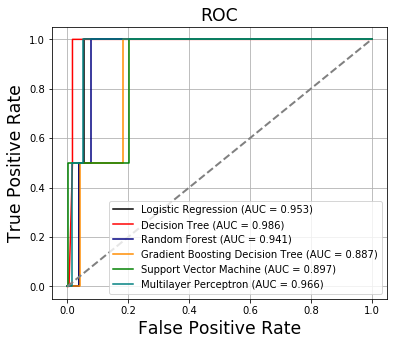

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Unrecognized location 'high right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


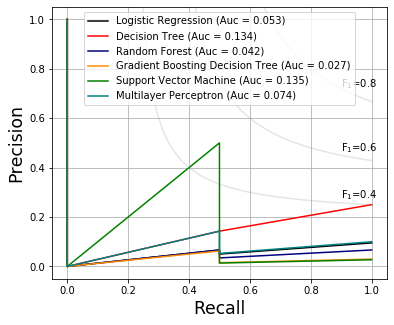

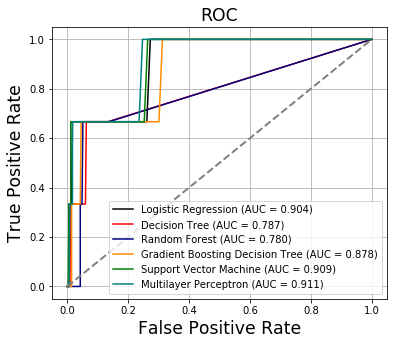

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Unrecognized location 'high right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


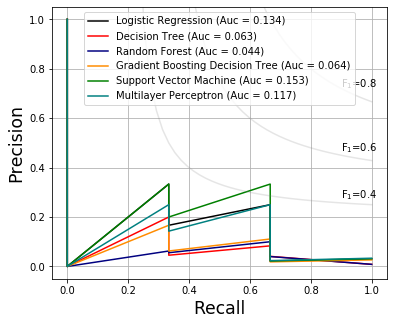

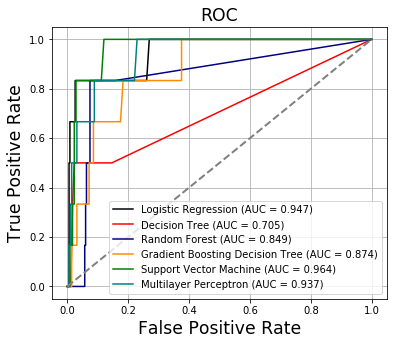

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Unrecognized location 'high right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


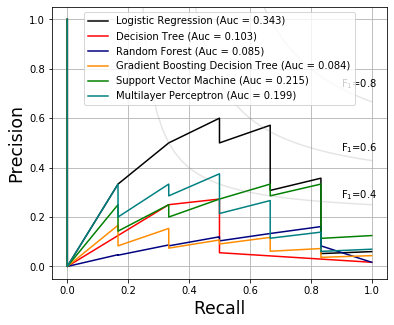

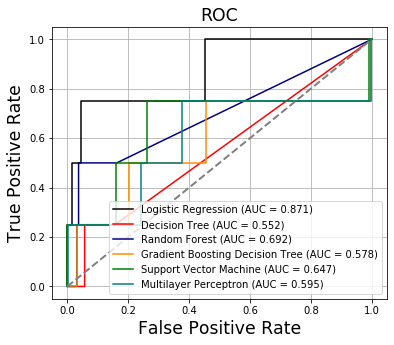

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Unrecognized location 'high right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


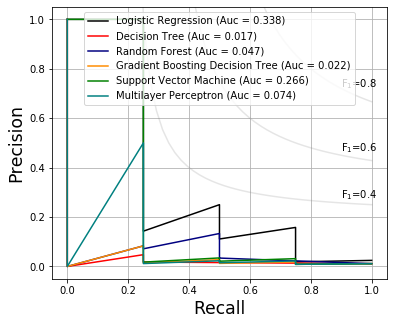

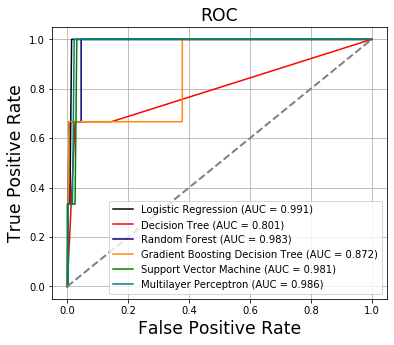

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Unrecognized location 'high right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


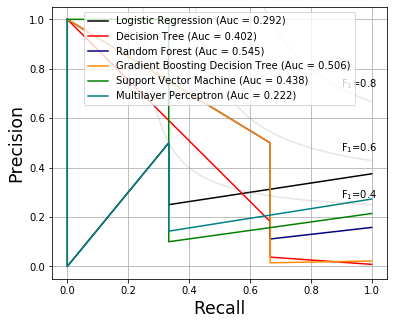

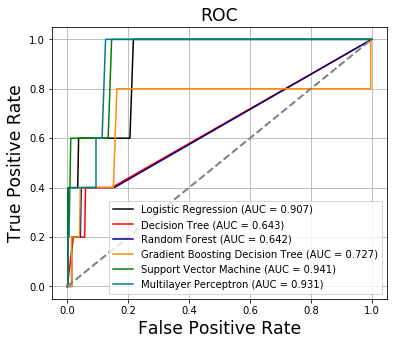

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Unrecognized location 'high right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


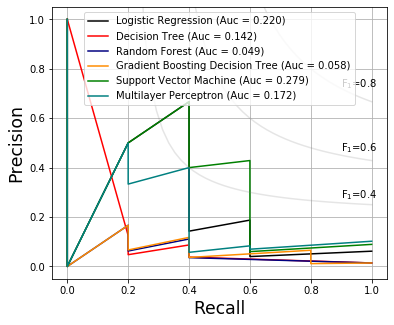

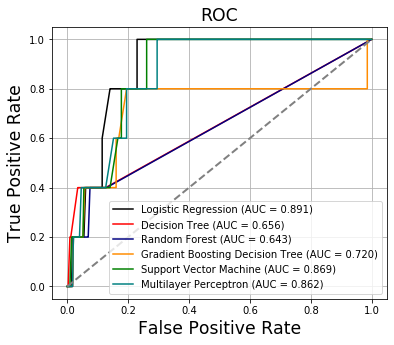

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Unrecognized location 'high right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


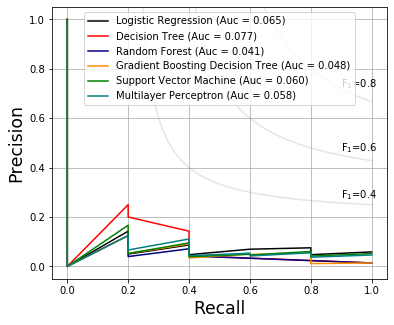

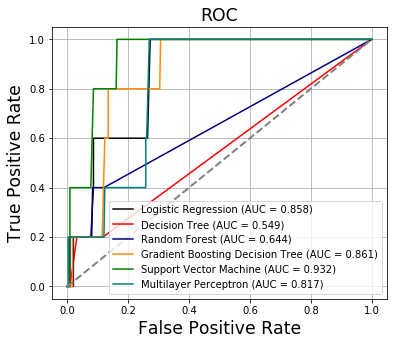

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Unrecognized location 'high right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


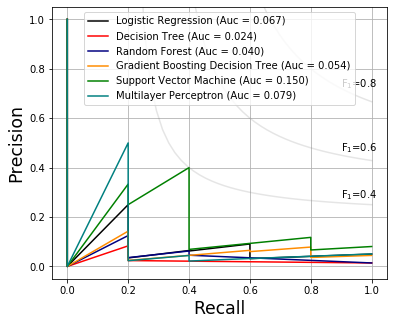

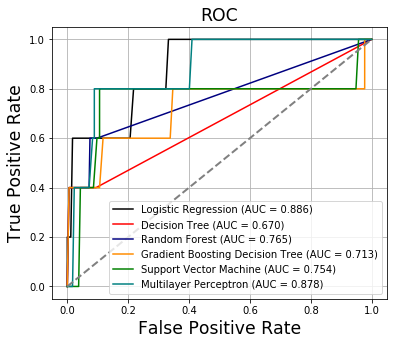

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Unrecognized location 'high right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


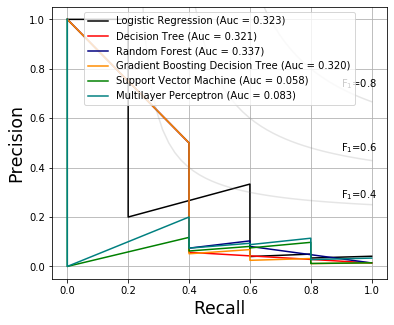

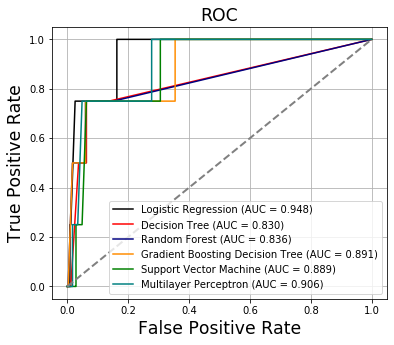

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Unrecognized location 'high right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


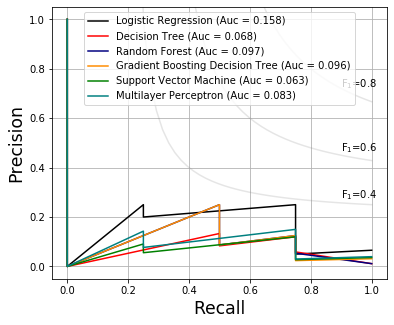

In [127]:
acc_save, sen_save, spe_save, pre_save, f1_save, roc_auc_save, pr_auc_save, pearson_r_save, fold_save = [],[],[],[],[],[],[],[],[]

for i in range(len(cv_y)):
    
    #SMOTE
    smote = SMOTE(sampling_strategy = 1,random_state=0)
    smote_train_x, smote_train_y = smote.fit_sample(train_x[i],train_y[i])
    
    #Model
    model1 = LogisticRegression(C=Hyperparameter_1, random_state=0)
    model1.fit(smote_train_x, smote_train_y)
    
    model2 = tree.DecisionTreeClassifier(max_depth=Hyperparameter_2,random_state=0)
    model2.fit(smote_train_x, smote_train_y)
    
    model3 = RandomForestClassifier(n_estimators=Hyperparameter_3,random_state=0)
    model3.fit(smote_train_x, smote_train_y)

    model4 = GradientBoostingClassifier(max_depth=Hyperparameter_4,random_state=0)
    model4.fit(smote_train_x, smote_train_y)

    model5 = SVC(C=Hyperparameter_5,random_state=0, probability=True,kernel='linear')
    model5.fit(smote_train_x, smote_train_y)

    model6 = MLPClassifier(max_iter=1000, alpha=Hyperparameter_6, random_state=0,hidden_layer_sizes=(5,10))
    model6.fit(smote_train_x, smote_train_y)
    
    #Predict
    Predict_test_model1 = model1.predict_proba(cv_x[i])[:,1]
    Predict_test_model2 = model2.predict_proba(cv_x[i])[:,1]
    Predict_test_model3 = model3.predict_proba(cv_x[i])[:,1]
    Predict_test_model4 = model4.predict_proba(cv_x[i])[:,1]
    Predict_test_model5 = model5.predict_proba(cv_x[i])[:,1]
    Predict_test_model6 = model6.predict_proba(cv_x[i])[:,1]
    #Predict_test_model7 = cv_bsrs[i]
    
    Proba_test_1 = model1.predict(cv_x[i])
    Proba_test_2 = model2.predict(cv_x[i])
    Proba_test_3 = model3.predict(cv_x[i])
    Proba_test_4 = model4.predict(cv_x[i])
    Proba_test_5 = model5.predict(cv_x[i])
    Proba_test_6 = model6.predict(cv_x[i])
    #Proba_test_7 = bsrs_predict_data(np.array(cv_bsrs[i]),10)

    #print("=== 邏輯回歸 ===")
    acc, sen, spe, pre, f1, roc_auc, pr_auc, pearson_r = model_Verification(cv_y[i], cv_suicide[i], Proba_test_1, Predict_test_model1)
    acc_save, sen_save, spe_save, pre_save, f1_save, roc_auc_save, pr_auc_save, pearson_r_save, fold_save = save_value(acc, sen, spe, pre, f1, roc_auc, pr_auc, pearson_r, i, acc_save, sen_save, spe_save, pre_save, f1_save, roc_auc_save, pr_auc_save, pearson_r_save, fold_save)
    #print("=== 決策樹 ===")
    acc, sen, spe, pre, f1, roc_auc, pr_auc, pearson_r = model_Verification(cv_y[i], cv_suicide[i], Proba_test_2, Predict_test_model2)
    acc_save, sen_save, spe_save, pre_save, f1_save, roc_auc_save, pr_auc_save, pearson_r_save, fold_save = save_value(acc, sen, spe, pre, f1, roc_auc, pr_auc, pearson_r, i, acc_save, sen_save, spe_save, pre_save, f1_save, roc_auc_save, pr_auc_save, pearson_r_save, fold_save)
    #print("=== 隨機森林 ===")
    acc, sen, spe, pre, f1, roc_auc, pr_auc, pearson_r = model_Verification(cv_y[i], cv_suicide[i], Proba_test_3, Predict_test_model3)
    acc_save, sen_save, spe_save, pre_save, f1_save, roc_auc_save, pr_auc_save, pearson_r_save, fold_save = save_value(acc, sen, spe, pre, f1, roc_auc, pr_auc, pearson_r, i, acc_save, sen_save, spe_save, pre_save, f1_save, roc_auc_save, pr_auc_save, pearson_r_save, fold_save)
    #print("=== 梯度提升決策樹 ===")
    acc, sen, spe, pre, f1, roc_auc, pr_auc, pearson_r = model_Verification(cv_y[i], cv_suicide[i], Proba_test_4, Predict_test_model4)
    acc_save, sen_save, spe_save, pre_save, f1_save, roc_auc_save, pr_auc_save, pearson_r_save, fold_save = save_value(acc, sen, spe, pre, f1, roc_auc, pr_auc, pearson_r, i, acc_save, sen_save, spe_save, pre_save, f1_save, roc_auc_save, pr_auc_save, pearson_r_save, fold_save)
    #print("=== 支持向量機 ===")
    acc, sen, spe, pre, f1, roc_auc, pr_auc, pearson_r = model_Verification(cv_y[i], cv_suicide[i], Proba_test_5, Predict_test_model5)
    acc_save, sen_save, spe_save, pre_save, f1_save, roc_auc_save, pr_auc_save, pearson_r_save, fold_save = save_value(acc, sen, spe, pre, f1, roc_auc, pr_auc, pearson_r, i, acc_save, sen_save, spe_save, pre_save, f1_save, roc_auc_save, pr_auc_save, pearson_r_save, fold_save)
    #print("=== 多層感知器 ===")
    acc, sen, spe, pre, f1, roc_auc, pr_auc, pearson_r = model_Verification(cv_y[i], cv_suicide[i], Proba_test_6, Predict_test_model6)
    acc_save, sen_save, spe_save, pre_save, f1_save, roc_auc_save, pr_auc_save, pearson_r_save, fold_save = save_value(acc, sen, spe, pre, f1, roc_auc, pr_auc, pearson_r, i, acc_save, sen_save, spe_save, pre_save, f1_save, roc_auc_save, pr_auc_save, pearson_r_save, fold_save)
    #print("=== BSRS ===")
    #acc, sen, spe, pre, f1, roc_auc, pr_auc, pearson_r = model_Verification(cv_y[i], cv_suicide[i], Proba_test_7, Predict_test_model7)
    #acc_save, sen_save, spe_save, pre_save, f1_save, roc_auc_save, pr_auc_save, pearson_r_save, fold_save = save_value(acc, sen, spe, pre, f1, roc_auc, pr_auc, pearson_r, i, acc_save, sen_save, spe_save, pre_save, f1_save, roc_auc_save, pr_auc_save, pearson_r_save, fold_save)
    
    #ROC
    plt.figure(figsize=(6,5))
    
    fpr, tpr, thresholds = roc_curve(y_true=cv_y[i], y_score=Predict_test_model1) 
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr,tpr,color='black',label='%s (AUC = %0.3f)' % ('Logistic Regression', roc_auc))
    
    fpr, tpr, thresholds = roc_curve(y_true=cv_y[i], y_score=Predict_test_model2) 
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr,tpr,color='r',label='%s (AUC = %0.3f)' % ('Decision Tree', roc_auc))
    
    fpr, tpr, thresholds = roc_curve(y_true=cv_y[i], y_score=Predict_test_model3) 
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr,tpr,color='navy',label='%s (AUC = %0.3f)' % ('Random Forest', roc_auc))

    fpr, tpr, thresholds = roc_curve(y_true=cv_y[i], y_score=Predict_test_model4) 
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr,tpr,color='darkorange',label='%s (AUC = %0.3f)' % ('Gradient Boosting Decision Tree', roc_auc))

    fpr, tpr, thresholds = roc_curve(y_true=cv_y[i], y_score=Predict_test_model5) 
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr,tpr,color='green',label='%s (AUC = %0.3f)' % ('Support Vector Machine', roc_auc))

    fpr, tpr, thresholds = roc_curve(y_true=cv_y[i], y_score=Predict_test_model6) 
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr,tpr,color='teal',label='%s (AUC = %0.3f)' % ('Multilayer Perceptron', roc_auc))

    #fpr, tpr, thresholds = roc_curve(y_true=cv_y[i], y_score=Predict_test_model7) 
    #roc_auc = auc(x=fpr, y=tpr)
    #plt.plot(fpr,tpr,color='skyblue',label='%s (AUC = %0.3f)' % ('BSRS', roc_auc))

    plt.legend(loc='lower right')
    plt.title("ROC" ,size ='xx-large')
    plt.plot([0, 1],[0, 1],linestyle='--',color='gray',linewidth=2,)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.grid()
    plt.xlabel('False Positive Rate',size ='xx-large')
    plt.ylabel('True Positive Rate',size ='xx-large')
    plt.show()

    #PR
    plt.figure(figsize=(6,5))

    precision, recall, thresholds = precision_recall_curve(cv_y[i], Predict_test_model1)
    pr_auc = auc(x=recall, y=precision)
    plt.plot(recall,precision,color='black',label='%s (Auc = %0.3f)' % ('Logistic Regression', pr_auc))

    precision, recall, thresholds = precision_recall_curve(cv_y[i], Predict_test_model2)
    pr_auc = auc(x=recall, y=precision)
    plt.plot(recall,precision,color='r',label='%s (Auc = %0.3f)' % ('Decision Tree', pr_auc))

    precision, recall, thresholds = precision_recall_curve(cv_y[i], Predict_test_model3)
    pr_auc = auc(x=recall, y=precision)
    plt.plot(recall,precision,color='navy',label='%s (Auc = %0.3f)' % ('Random Forest', pr_auc))

    precision, recall, thresholds = precision_recall_curve(cv_y[i], Predict_test_model4)
    pr_auc = auc(x=recall, y=precision)
    plt.plot(recall,precision,color='darkorange',label='%s (Auc = %0.3f)' % ('Gradient Boosting Decision Tree', pr_auc))

    precision, recall, thresholds = precision_recall_curve(cv_y[i], Predict_test_model5)
    pr_auc = auc(x=recall, y=precision)
    plt.plot(recall,precision,color='green',label='%s (Auc = %0.3f)' % ('Support Vector Machine', pr_auc))

    precision, recall, thresholds = precision_recall_curve(cv_y[i], Predict_test_model6)
    pr_auc = auc(x=recall, y=precision)
    plt.plot(recall,precision,color='teal',label='%s (Auc = %0.3f)' % ('Multilayer Perceptron', pr_auc))

    #precision, recall, thresholds = precision_recall_curve(cv_y[i], Predict_test_model7)
    #pr_auc = auc(x=recall, y=precision)
    #plt.plot(recall,precision,color='skyblue',label='%s (Auc = %0.3f)' % ('BSRS', pr_auc))
    
    plt.legend(loc='high right')

    f_scores = np.linspace(0.4, 0.8, num=3)
    lines = []
    labels = []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
        plt.annotate('F$_1$={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02)) 
    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.grid()
    plt.xlabel('Recall',size ='xx-large')
    plt.ylabel('Precision',size ='xx-large')
    plt.show()

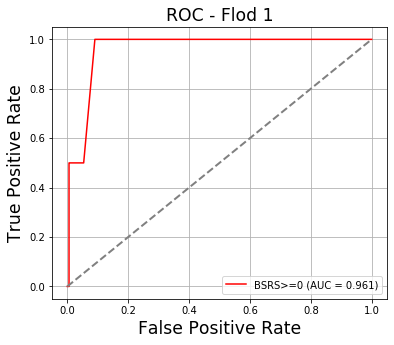

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Unrecognized location 'high right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


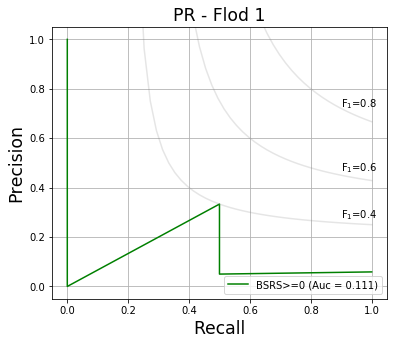

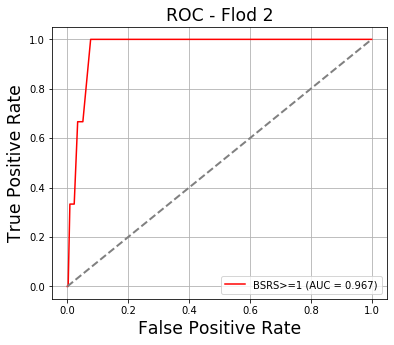

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Unrecognized location 'high right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


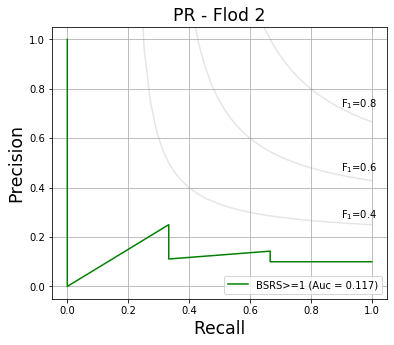

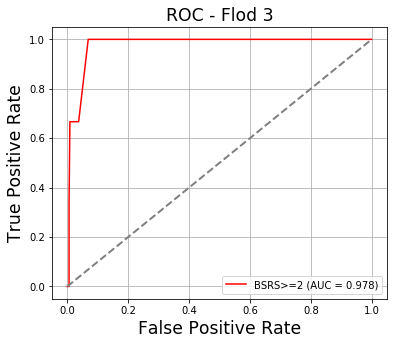

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Unrecognized location 'high right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


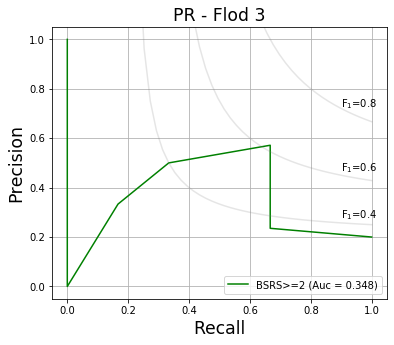

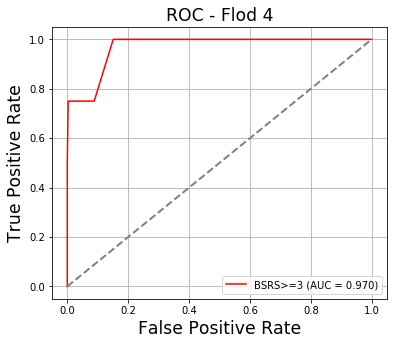

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Unrecognized location 'high right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


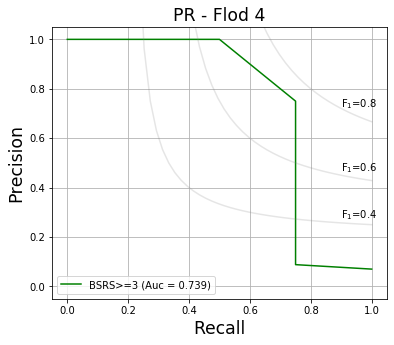

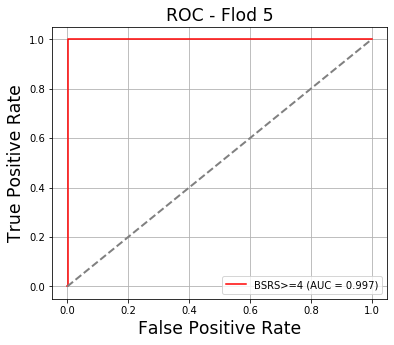

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Unrecognized location 'high right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


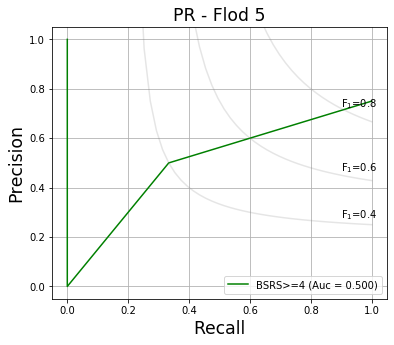

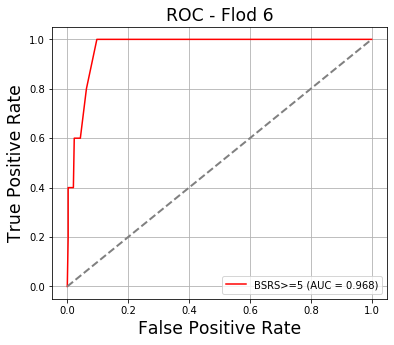

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Unrecognized location 'high right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


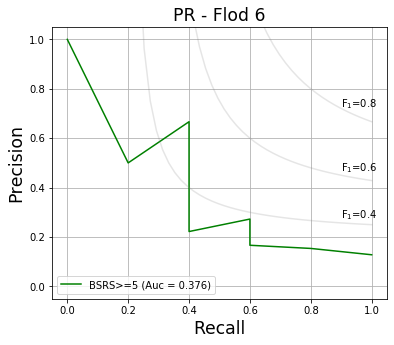

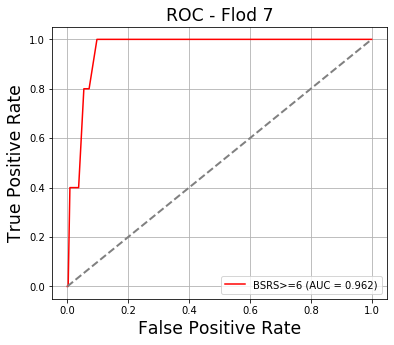

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Unrecognized location 'high right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


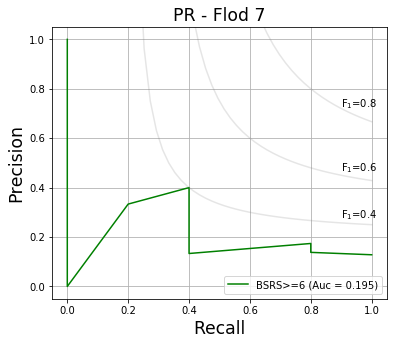

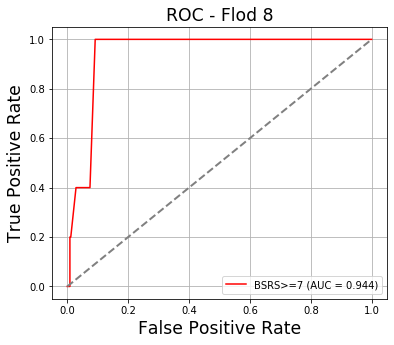

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Unrecognized location 'high right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


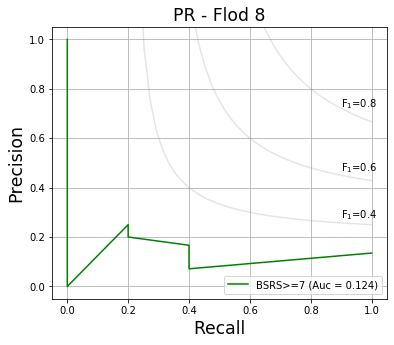

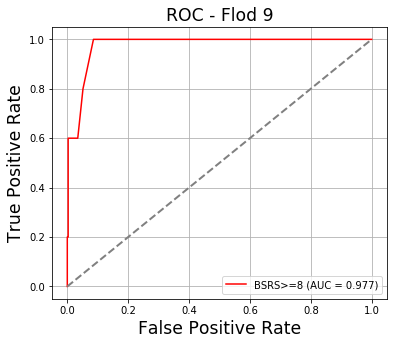

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Unrecognized location 'high right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


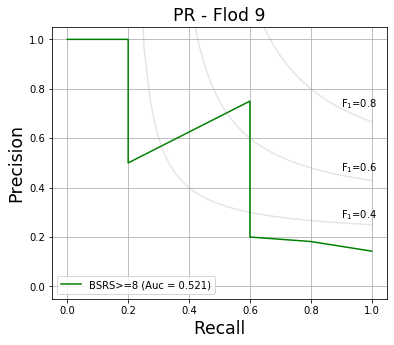

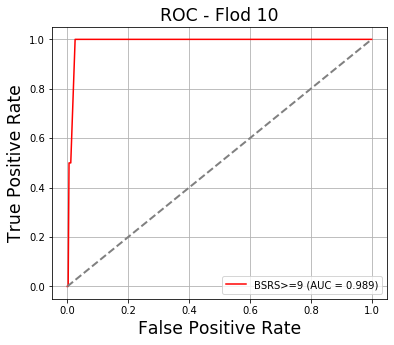

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Unrecognized location 'high right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


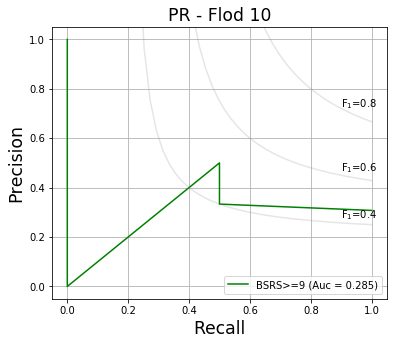

In [124]:
acc_save, sen_save, spe_save, pre_save, f1_save, roc_auc_save, pr_auc_save, pearson_r_save, fold_save = [],[],[],[],[],[],[],[],[]
BSRS_name = ['BSRS>=0','BSRS>=1','BSRS>=2','BSRS>=3','BSRS>=4','BSRS>=5','BSRS>=6','BSRS>=7','BSRS>=8','BSRS>=9','BSRS>=10']
for i in range(len(cv_y)):
    
    #Predict
    Predict_test_model7 = cv_bsrs[i]
    
    Proba_test_7_list = []
    for j in np.arange(1, 11, 1):
        Proba_test_7 = bsrs_predict_data(np.array(cv_bsrs[i]),j)
        acc, sen, spe, pre, f1, roc_auc, pr_auc, pearson_r = model_Verification(cv_y[i], cv_suicide[i], Proba_test_7, Predict_test_model7)
        acc_save, sen_save, spe_save, pre_save, f1_save, roc_auc_save, pr_auc_save, pearson_r_save, fold_save = save_value(acc, sen, spe, pre, f1, roc_auc, pr_auc, pearson_r, i, acc_save, sen_save, spe_save, pre_save, f1_save, roc_auc_save, pr_auc_save, pearson_r_save, fold_save)
    
    #ROC
    plt.figure(figsize=(6,5))

    fpr, tpr, thresholds = roc_curve(y_true=cv_y[i], y_score=Predict_test_model7) 
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr,tpr,color='r',label='%s (AUC = %0.3f)' % (BSRS_name[i], roc_auc))
    
    plt.legend(loc='lower right')
    plt.title("ROC - Flod %s" %(i+1),size ='xx-large')
    plt.plot([0, 1],[0, 1],linestyle='--',color='gray',linewidth=2,)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.grid()
    plt.xlabel('False Positive Rate',size ='xx-large')
    plt.ylabel('True Positive Rate',size ='xx-large')
    plt.show()

    #PR
    plt.figure(figsize=(6,5))

    precision, recall, thresholds = precision_recall_curve(cv_y[i], Predict_test_model7)
    pr_auc = auc(x=recall, y=precision)
    plt.plot(recall,precision,color='g',label='%s (Auc = %0.3f)' % (BSRS_name[i], pr_auc))
    
    plt.legend(loc='high right')
    plt.title("PR - Flod %s" %(i+1),size ='xx-large')
    f_scores = np.linspace(0.4, 0.8, num=3)
    lines = []
    labels = []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
        plt.annotate('F$_1$={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02)) 
    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.grid()
    plt.xlabel('Recall',size ='xx-large')
    plt.ylabel('Precision',size ='xx-large')
    plt.show()